# Real Estate Prices & Venues Data Analysis of London - Coursera Capstone Project

This notebook contains the code for the Coursera Capstone Project on Data Science by IBM and Coursera

# Introduction and Business Problem

#### Introduction:

- London is the capital of and largest city in England and the United Kingdom, with the largest municipal population in the European Union. London has a diverse range of people and cultures, and more than 300 languages are spoken in the region.Its estimated mid-2016 municipal population (corresponding to Greater London) was 8,787,892, the most populous of any city in the European Union and accounting for 13.4% of the UK population. London’s urban area is the second most populous in the EU, after Paris, with 9,787,426 inhabitants at the 2011 census. The population density is 14,500/sq mi.[1]

#### Business Problem:

- London is a city with a high population and population density. As from Real Estate investor point of view we want to invest in such places were the housing prices are low and the facilities(shops,restaurants,parks,Hotels, etc.) and social venues are nearby. Keeping above things in mind it is very difficult for an individual to find such place in such big city and gather this much information. When we consider all these problems, we can create a map and information chart where the real estate index is placed on London and each district is clustered according to the venue density.

## Data Required

The data that will be used to adress the avobe problem are:

- List of areas of London was found with its boroughs and postcodes from Wikipedia.
- For housing prices, I found a website (https://propertydata.co.uk/cities/london) where latest London house prices were available with the postal codes.
- Forsquare API will be used to get the most common venues of given Borough of London.
- For chloropleth maps I used .geojson file of London.

# Importing Libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geocoder 
import geocoder as geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    geocoder:        1.38.1-py_1       conda-forge
    ratelim:         0.1.6-py_2        conda-forge

The following packages will be UPDATED:

    

# Scraping Data from Wikipedia

In [5]:
#Get the html source
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_areas_of_London")[1]
df.head()

Location                     London borough       Post town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode district Dial code OS grid ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

In [6]:
df.shape

(533, 6)

In [7]:
df.columns

Index(['Location', 'London borough', 'Post town', 'Postcode district',
       'Dial code', 'OS grid ref'],
      dtype='object')

In [8]:
df.columns = ['Location','London_borough','Post town','Postcode district','Dial Code','OS grid ref']

## Cleaning the table

We are only going to keep the columns "location", "london borough" and "postcode district" and correct the column names

In [9]:
df.drop(columns=['Post town','Dial Code','OS grid ref'],inplace=True) #drop unwanted columns

In [10]:
df.columns = ['Location','London_borough','Postcode_district']

The table contains hyperlink numbers and multiple entries in Boroughs and Postcodes so we'll just keep one

In [11]:
df['London_borough'] =  df['London_borough'].apply(lambda x: x.replace('[','').replace(']','')) 
df['London_borough'] =  df['London_borough'].str.replace('\d+', '')
df['London_borough'] =  df['London_borough'].str.split(',').str[0]
df['Postcode_district'] =  df['Postcode_district'].str.split(',').str[0]
df['Postcode_district'] =  df['Postcode_district'].str.split('(').str[0]

In [12]:
df.shape

(533, 3)

In [13]:
df.head()

Location London_borough Postcode_district
0   Abbey Wood         Bexley               SE2
1        Acton         Ealing                W3
2    Addington        Croydon               CR0
3   Addiscombe        Croydon               CR0
4  Albany Park         Bexley               DA5

# Getting property data of London

In [14]:
propdata = pd.read_html("https://propertydata.co.uk/cities/london",header=0)
df2=pd.DataFrame(data=propdata[0])
df2.head()

Area Avg yield Avg price £/sqft 5yr +/-  Explore data
0  BR1      3.6%  £439,075   £465    +24%  Explore data
1  BR2      3.4%  £484,921   £469    +25%  Explore data
2  BR3      3.8%  £420,887   £492    +25%  Explore data
3  BR5         -  £469,526   £428    +24%  Explore data
4  BR6      2.9%  £563,886   £465    +25%  Explore data

# Cleaning property data

The columns we need are just "Area" and "Avg price".

In [15]:
df2.drop(columns=['Avg yield','£/sqft','5yr +/-','Explore data'],inplace=True)
df2.head()

Area Avg price
0  BR1  £439,075
1  BR2  £484,921
2  BR3  £420,887
3  BR5  £469,526
4  BR6  £563,886

We also have to correct the "Avg price" columns so we can use it.

In [16]:
df2['Avg price'] = df2['Avg price'].str.replace("£","")
df2['Avg price'] = df2['Avg price'].str.replace(',', '')
df2['Avg price'] = pd.to_numeric(df2['Avg price'])
df2.head()

Area  Avg price
0  BR1     439075
1  BR2     484921
2  BR3     420887
3  BR5     469526
4  BR6     563886

In [17]:
df2.columns=['Postcode_district','Avg_price']

# Merge the tables of London Boroughs and London House Prices

In [18]:
data=pd.merge(df, df2, how='inner', left_on='Postcode_district', right_on='Postcode_district')
data.head()

Location London_borough Postcode_district  Avg_price
0  Abbey Wood         Bexley               SE2     360798
1   Crossness         Bexley               SE2     360798
2  West Heath         Bexley               SE2     360798
3       Acton         Ealing                W3     552251
4   Addington        Croydon               CR0     346268

# Finding Longitude and Langitude of the Locations

In [19]:
def getLatLong(row):
    #print('post :{}'.format(row[:]))
    #print('neigh :{}'.format(row[1]))
    # initialize your variable to None
    lat_lng_coords = None
    search_query = '{}, London,UK'.format(row)
    # loop until you get the coordinates
    try:
        while(lat_lng_coords is None):
            #g = geocoder.here(search_query,app_id=app_id,app_code=app_code)
            g = geocoder.arcgis(search_query)
            lat_lng_coords = g.latlng
            #print('FIRST')
    except IndexError:
        latitude = 0.0
        longitude = 0.0
        print('BACKUP')
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print(latitude, longitude)
    return [latitude, longitude]

In [20]:
coords_list = data['Postcode_district'].apply(getLatLong).tolist()

51.492450000000076 0.12127000000003818
51.492450000000076 0.12127000000003818
51.492450000000076 0.12127000000003818
51.51324000000005 -0.2674599999999714
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.38475500000004 -0.051498623999975734
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.51200000000006 -0.08057999999994081
51.51200000000006 -0.08057999999994081
51.51651000000004 -0.11967999999995982
51.51651000000004 -0.11967999999995982
51.51651000000004 -0.11967999999995982
51.51651000000004 -0.11967999999995982
51.50642000000005 -0.12

# Add the coordinates in the dataframe

In [21]:
data[['Latitude','Longitude']]=pd.DataFrame(coords_list,columns=['Latitude', 'Longitude'])
data.head()

Location London_borough Postcode_district  Avg_price   Latitude  \
0  Abbey Wood         Bexley               SE2     360798  51.492450   
1   Crossness         Bexley               SE2     360798  51.492450   
2  West Heath         Bexley               SE2     360798  51.492450   
3       Acton         Ealing                W3     552251  51.513240   
4   Addington        Croydon               CR0     346268  51.384755   

   Longitude  
0   0.121270  
1   0.121270  
2   0.121270  
3  -0.267460  
4  -0.051499

#### Use geopy library to get the latitude and longitude values of London.

In [22]:
address = 'London'
geolocator = Nominatim(user_agent="ldn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


# Create a map of London with neighborhoods superimposed on top.

In [23]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['London_borough'], data['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

# Making use of the Foursquare API

## Define Foursquare Credentials and Version

In [24]:
CLIENT_ID = 'OV2PQJTJXOC1TCDBATTOMEQUR5B4RCADV2ALLWPBV32CUDS2' # your Foursquare ID
CLIENT_SECRET = '4FELM30UIU5PCGMW2HYOQCKRKHCRXG0RAJSTKS0RAKVMIJPG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OV2PQJTJXOC1TCDBATTOMEQUR5B4RCADV2ALLWPBV32CUDS2
CLIENT_SECRET:4FELM30UIU5PCGMW2HYOQCKRKHCRXG0RAJSTKS0RAKVMIJPG


In [25]:
LIMIT = 100
radius = 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Code to run the above function on each neighborhood and create a new dataframe called london_venues.

In [26]:
london_venues = getNearbyVenues(names=data['Location'], 
                                   latitudes=data['Latitude'], 
                                   longitudes=data['Longitude'], 
                                   radius=500)

In [27]:
london_venues.shape

(21733, 7)

In [28]:
london_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Abbey Wood               51.49245                 0.12127   
1   Abbey Wood               51.49245                 0.12127   
2   Abbey Wood               51.49245                 0.12127   
3   Abbey Wood               51.49245                 0.12127   
4   Abbey Wood               51.49245                 0.12127   

                              Venue  Venue Latitude  Venue Longitude  \
0                       Sainsbury's       51.492824         0.120724   
1                              Lidl       51.496152         0.118417   
2                      Lesnes Abbey       51.489526         0.125839   
3  Abbey Wood Railway Station (ABW)       51.490825         0.123432   
4                    The Abbey Arms       51.490693         0.121182   

  Venue Category  
0    Supermarket  
1    Supermarket  
2  Historic Site  
3  Train Station  
4            Pub

## Number of Venues returned for every Neighborhood

In [29]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                            
Abbey Wood                                                          8   
Acton                                                               8   
Addington                                                           1   
Addiscombe                                                          1   
Albany Park                                                       100   
Aldborough Hatch                                                  100   
Aldgate                                                           100   
Aldwych                                                           100   
Alperton                                                          100   
Anerley                                                             6   
Angel                                                              82   
Aperfield                                                           2   
Archway                                                            30   
Ardleigh Green                                                      5   
Arkley                                                              4   
Arnos Grove                                                         8   
Balham                                                             35   
Bankside                                                           43   
Barbican                                                           82   
Barking                                                             5   
Barkingside                                                       100   
Barnehurst                                                          5   
Barnes                                                             23   
Barnes Cray                                                         5   
Barnet (also Chipping Barnet, High Barnet)                          4   
Barnet Gate                                                        17   
Barnsbury                                                          88   
Battersea                                                          26   
Bayswater                                                         100   
Beckenham                                                           4   
Beckton                                                            13   
Becontree                                                         100   
Becontree Heath                                                   100   
Beddington                                                          4   
Bedford Park                                                       40   
Belgravia                                                          99   
Bellingham                                                          7   
Belmont                                                           200   
Belsize Park                                                       51   
Belvedere                                                           9   
Bermondsey                                                         43   
Berrylands                                                        100   
Bethnal Green                                                      35   
Bexley (also Old Bexley, Bexley Village)                          100   
Bickley                                                             4   
Biggin Hill                                                         2   
Blackfen                                                            6   
Blackfriars                                                       100   
Blackheath                                                          3   
Blackheath Royal Standard                                           3   
Blackwall                                                          10   
Bloomsbury                                                         68   
Botany Bay                                                          2   
Bounds Green                     

Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 327 uniques categories.


## Lets Analyze Each Neighborhood

In [31]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  \
0   Abbey Wood                  0                  0                   0   
1   Abbey Wood                  0                  0                   0   
2   Abbey Wood                  0                  0                   0   
3   Abbey Wood                  0                  0                   0   
4   Abbey Wood                  0                  0                   0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                     0                 0                   0   
1                     0                 0                   0   
2                     0                 0                   0   
3                     0                 0                   0   
4                     0                 0                   0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                      0                    0            0              0   
1                      0                    0            0              0   
2                      0                    0            0              0   
3                      0                    0            0              0   
4                      0                    0            0              0   

   BBQ Joint  Bagel Shop  Bakery  Bar  Beach  Bed & Breakfast  Beer Bar  \
0          0           0       0    0      0                0         0   
1          0           0       0    0      0                0         0   
2          0           0       0    0      0                0         0   
3          0           0       0    0      0                0         0   
4          0           0       0    0      0                0         0   

   Beer Garden  Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  \
0            0           0             0                         0          0   
1            0           0             0                         0          0   
2            0           0             0                         0          0   
3            0           0             0                         0          0   
4            0           0             0                         0          0   

   Bistro  Boarding House  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0       0               0          0         0              0           0   
1       0               0          0         0              0           0   
2       0               0          0         0              0           0   
3       0               0          0         0              0           0   
4       0               0          0         0              0           0   

   Brasserie  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0          0                     0               0        0            0   
1          0                     0               0        0            0   
2          0                     0               0        0            0   
3          0                     0               0        0            0   
4          0                     0               0        0   

And let's examine the new dataframe size.

In [32]:
london_onehot.shape

(21733, 328)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped.head()

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  \
0   Abbey Wood                0.0                0.0                0.00   
1        Acton                0.0                0.0                0.00   
2    Addington                0.0                0.0                0.00   
3   Addiscombe                0.0                0.0                0.00   
4  Albany Park                0.0                0.0                0.01   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                  0.0           0.0     0.0               0.0   
1                  0.0           0.0     0.0               0.0   
2                  0.0           0.0     0.0               0.0   
3                  0.0           0.0     0.0               0.0   
4                  0.0           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0         0.00        0.00                  0.0   
1                     0.0         0.00        0.00                  0.0   
2                     0.0         0.00        0.00                  0.0   
3                     0.0         0.00        0.00                  0.0   
4                     0.0         0.03        0.02                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0              0.00                 0.0   
1                   0.0              0.00                 0.0   
2                   0.0              0.00                 0.0   
3                   0.0              0.00                 0.0   
4                   0.0              0.01                 0.0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                    0.0                  0.0          0.0            0.0   
1                    0.0                  0.0          0.0            0.0   
2                    0.0                  0.0          0.0            0.0   
3                    0.0                  0.0          0.0            0.0   
4                    0.0                  0.0          0.0            0.0   

   BBQ Joint  Bagel Shop  Bakery   Bar  Beach  Bed & Breakfast  Beer Bar  \
0        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
1        0.0         0.0    0.00  0.00    0.0            0.125       0.0   
2        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
3        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
4        0.0         0.0    0.01  0.01    0.0            0.000       0.0   

   Beer Garden  Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  \
0          0.0         0.0           0.0                       0.0        0.0   
1          0.0         0.0           0.0                       0.0        0.0   
2          0.0         0.0           0.0                       0.0        0.0   
3          0.0         0.0           0.0                       0.0        0.0   
4          0.0         0.0           0.0                       0.0        0.0   

   Bistro  Boarding House  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0     0.0             0.0       0.00      0.00            0.0         0.0   
1     0.0             0.0       0.00      0.00            0.0         0.0   
2     0.0             0.0       0.00      0.00            0.0         0.0   
3     0.0             0.0       0.00      0.00            0.0         0.0   
4     0.0             0.0       0.01      0.01            0.0         0.0   

   Brasserie  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0        0.0                   0.0           0.000      0.0          0.0   
1        0.0                   0.0           0.125      0.0          0.0   
2        0.0                   0.0           0.000      0.0          0.0   
3        0.0                   0.0           0.000      0.0          0.0   
4        0.0                   0.0           0.000      


Let's confirm the new size

In [34]:
london_grouped.shape

(508, 328)

#### Let's print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
           venue  freq
0    Supermarket  0.25
1  Historic Site  0.12
2       Platform  0.12
3    Coffee Shop  0.12
4  Train Station  0.12


----Acton----
             venue  freq
0  Bed & Breakfast  0.12
1    Grocery Store  0.12
2      Gas Station  0.12
3    Train Station  0.12
4   Breakfast Spot  0.12


----Addington----
                   venue  freq
0          Grocery Store   1.0
1      Accessories Store   0.0
2              Pet Store   0.0
3     Persian Restaurant   0.0
4  Performing Arts Venue   0.0


----Addiscombe----
                   venue  freq
0          Grocery Store   1.0
1      Accessories Store   0.0
2              Pet Store   0.0
3     Persian Restaurant   0.0
4  Performing Arts Venue   0.0


----Albany Park----
                 venue  freq
0                Hotel  0.09
1              Theater  0.05
2                Plaza  0.04
3             Wine Bar  0.04
4  Monument / Landmark  0.04


----Aldborough Hatch----
                 venue  freq
0           

#### Let's put that into a pandas dataframe



First, let's write a function to sort the venues in descending order.


In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Abbey Wood           Supermarket                   Pub   
1        Acton       Bed & Breakfast         Grocery Store   
2    Addington         Grocery Store           Zoo Exhibit   
3   Addiscombe         Grocery Store           Zoo Exhibit   
4  Albany Park                 Hotel               Theater   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Train Station     Convenience Store           Coffee Shop   
1     Indian Restaurant        Breakfast Spot                  Park   
2    Falafel Restaurant  Fast Food Restaurant           Film Studio   
3    Falafel Restaurant  Fast Food Restaurant           Film Studio   
4   Monument / Landmark              Wine Bar                 Plaza   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Platform         Historic Site           Zoo Exhibit   
1         Train Station           Gas Station     Convenience Store   
2     Fish & Chips Shop           Fish Market           Flea Market   
3     Fish & Chips Shop           Fish Market           Flea Market   
4                   Pub     Outdoor Sculpture           Art Gallery   

  9th Most Common Venue 10th Most Common Venue  
0           Flea Market         Farmers Market  
1           Flower Shop   Fast Food Restaurant  
2           Flower Shop                   Food  
3           Flower Shop                   Food  
4                Garden      French Restaurant

In [38]:
neighborhoods_venues_sorted.rename(columns = {'Neighborhood':'Location'}, inplace = True)

## Adding Average house price of each Neighborhood in the Group

## Normalizing the Avg price column

In [39]:
london_grouped['Price']=data['Avg_price']
v= london_grouped.iloc[:, -1]
london_grouped.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())
london_grouped.head()

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  \
0   Abbey Wood                0.0                0.0                0.00   
1        Acton                0.0                0.0                0.00   
2    Addington                0.0                0.0                0.00   
3   Addiscombe                0.0                0.0                0.00   
4  Albany Park                0.0                0.0                0.01   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                  0.0           0.0     0.0               0.0   
1                  0.0           0.0     0.0               0.0   
2                  0.0           0.0     0.0               0.0   
3                  0.0           0.0     0.0               0.0   
4                  0.0           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0         0.00        0.00                  0.0   
1                     0.0         0.00        0.00                  0.0   
2                     0.0         0.00        0.00                  0.0   
3                     0.0         0.00        0.00                  0.0   
4                     0.0         0.03        0.02                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0              0.00                 0.0   
1                   0.0              0.00                 0.0   
2                   0.0              0.00                 0.0   
3                   0.0              0.00                 0.0   
4                   0.0              0.01                 0.0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                    0.0                  0.0          0.0            0.0   
1                    0.0                  0.0          0.0            0.0   
2                    0.0                  0.0          0.0            0.0   
3                    0.0                  0.0          0.0            0.0   
4                    0.0                  0.0          0.0            0.0   

   BBQ Joint  Bagel Shop  Bakery   Bar  Beach  Bed & Breakfast  Beer Bar  \
0        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
1        0.0         0.0    0.00  0.00    0.0            0.125       0.0   
2        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
3        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
4        0.0         0.0    0.01  0.01    0.0            0.000       0.0   

   Beer Garden  Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  \
0          0.0         0.0           0.0                       0.0        0.0   
1          0.0         0.0           0.0                       0.0        0.0   
2          0.0         0.0           0.0                       0.0        0.0   
3          0.0         0.0           0.0                       0.0        0.0   
4          0.0         0.0           0.0                       0.0        0.0   

   Bistro  Boarding House  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0     0.0             0.0       0.00      0.00            0.0         0.0   
1     0.0             0.0       0.00      0.00            0.0         0.0   
2     0.0             0.0       0.00      0.00            0.0         0.0   
3     0.0             0.0       0.00      0.00            0.0         0.0   
4     0.0             0.0       0.01      0.01            0.0         0.0   

   Brasserie  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0        0.0                   0.0           0.000      0.0          0.0   
1        0.0                   0.0           0.125      0.0          0.0   
2        0.0                   0.0           0.000      0.0          0.0   
3        0.0                   0.0           0.000      0.0          0.0   
4        0.0                   0.0           0.000      

# Clustering Neighborhoods

## Determine the correct number of clusters

In [41]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

In [42]:
london_grouped_clustering.head()

Accessories Store  Afghan Restaurant  African Restaurant  \
0                0.0                0.0                0.00   
1                0.0                0.0                0.00   
2                0.0                0.0                0.00   
3                0.0                0.0                0.00   
4                0.0                0.0                0.01   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                  0.0           0.0     0.0               0.0   
1                  0.0           0.0     0.0               0.0   
2                  0.0           0.0     0.0               0.0   
3                  0.0           0.0     0.0               0.0   
4                  0.0           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0         0.00        0.00                  0.0   
1                     0.0         0.00        0.00                  0.0   
2                     0.0         0.00        0.00                  0.0   
3                     0.0         0.00        0.00                  0.0   
4                     0.0         0.03        0.02                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0              0.00                 0.0   
1                   0.0              0.00                 0.0   
2                   0.0              0.00                 0.0   
3                   0.0              0.00                 0.0   
4                   0.0              0.01                 0.0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                    0.0                  0.0          0.0            0.0   
1                    0.0                  0.0          0.0            0.0   
2                    0.0                  0.0          0.0            0.0   
3                    0.0                  0.0          0.0            0.0   
4                    0.0                  0.0          0.0            0.0   

   BBQ Joint  Bagel Shop  Bakery   Bar  Beach  Bed & Breakfast  Beer Bar  \
0        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
1        0.0         0.0    0.00  0.00    0.0            0.125       0.0   
2        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
3        0.0         0.0    0.00  0.00    0.0            0.000       0.0   
4        0.0         0.0    0.01  0.01    0.0            0.000       0.0   

   Beer Garden  Beer Store  Betting Shop  Bike Rental / Bike Share  Bike Shop  \
0          0.0         0.0           0.0                       0.0        0.0   
1          0.0         0.0           0.0                       0.0        0.0   
2          0.0         0.0           0.0                       0.0        0.0   
3          0.0         0.0           0.0                       0.0        0.0   
4          0.0         0.0           0.0                       0.0        0.0   

   Bistro  Boarding House  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0     0.0             0.0       0.00      0.00            0.0         0.0   
1     0.0             0.0       0.00      0.00            0.0         0.0   
2     0.0             0.0       0.00      0.00            0.0         0.0   
3     0.0             0.0       0.00      0.00            0.0         0.0   
4     0.0             0.0       0.01      0.01            0.0         0.0   

   Brasserie  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0        0.0                   0.0           0.000      0.0          0.0   
1        0.0                   0.0           0.125      0.0          0.0   
2        0.0                   0.0           0.000      0.0          0.0   
3        0.0                   0.0           0.000      0.0          0.0   
4        0.0                   0.0           0.000      0.0          0.0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place 

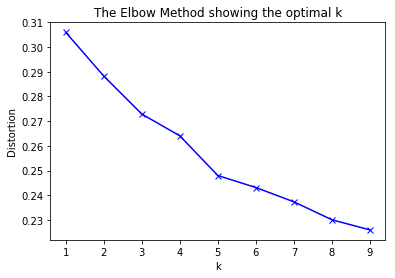

In [45]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(london_grouped_clustering)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(sum(np.min(cdist(london_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



Run k-means to cluster the neighborhood into 5 clusters.


In [159]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 5, 5, 0, 0, 0, 0, 0, 1], dtype=int32)

In [160]:
neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)



Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [161]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Location'), on='Location').dropna()

london_merged.head() # check the last columns!

Location London_borough Postcode_district  Avg_price   Latitude  \
0  Abbey Wood         Bexley               SE2     359190  51.492450   
1   Crossness         Bexley               SE2     359190  51.492450   
2  West Heath         Bexley               SE2     359190  51.492450   
3       Acton         Ealing                W3     553090  51.513240   
4   Addington        Croydon               CR0     345570  51.384755   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0   0.121270             3.0           Supermarket                   Pub   
1   0.121270             3.0           Supermarket                   Pub   
2   0.121270             3.0           Supermarket                   Pub   
3  -0.267460             1.0                  Park           Gas Station   
4  -0.051499             5.0         Grocery Store           Zoo Exhibit   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop         Historic Site         Train Station   
1           Coffee Shop         Historic Site         Train Station   
2           Coffee Shop         Historic Site         Train Station   
3        Breakfast Spot     Indian Restaurant         Train Station   
4           Gaming Cafe     Fish & Chips Shop           Fish Market   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Convenience Store              Platform           Zoo Exhibit   
1     Convenience Store              Platform           Zoo Exhibit   
2     Convenience Store              Platform           Zoo Exhibit   
3     Convenience Store         Grocery Store           Zoo Exhibit   
4           Flea Market           Flower Shop                  Food   

  9th Most Common Venue 10th Most Common Venue  
0     Food & Drink Shop      Fish & Chips Shop  
1     Food & Drink Shop      Fish & Chips Shop  
2     Food & Drink Shop      Fish & Chips Shop  
3     Food & Drink Shop            Fish Market  
4     Food & Drink Shop             Food Court

#### Droping the rows with null values

In [162]:
london_merged.dropna(inplace=True)

In [163]:
london_merged.dtypes

Location                   object
London_borough             object
Postcode_district          object
Avg_price                   int64
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

#### Because of null values the data type of 'Cluster Labels' was changed from int to float so converting it back to int

In [164]:
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)
london_merged.dtypes

Location                   object
London_borough             object
Postcode_district          object
Avg_price                   int64
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

### There were many Location that were assigned the same postcodes as they were very near so droping the duplicate postcodes

In [165]:
london_merged.drop_duplicates(subset='Postcode_district',inplace=True)

In [166]:
london_merged.reset_index(inplace=True)
london_merged.drop(columns='index',inplace=True)

## Visualize the clusters

In [167]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'],london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Binning

## There is the range of Avg price so binned the price into 7 distinct values

### ('Low level 1', 'Low level 2', 'Average level 1', 'Average level 2','Above Average','High level 1','High level 2')

Visualizing the bins

Text(0.5, 1.0, 'Price bins')

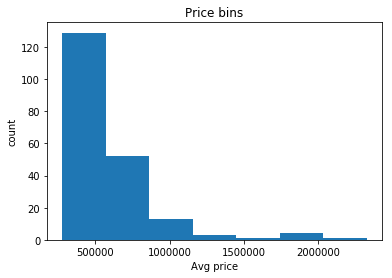

In [168]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(london_merged["Avg_price"],bins=7)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

In [169]:
bins = np.linspace(min(london_merged["Avg_price"]), max(london_merged["Avg_price"]), 8)
bins

array([ 277857.,  570556.,  863255., 1155954., 1448653., 1741352.,
       2034051., 2326750.])

In [170]:
group_names = ['Low level 1', 'Low level 2', 'Average level 1', 'Average level 2','Above Average','High level 1','High level 2']

In [171]:
london_merged['Price-Categories'] = pd.cut(london_merged['Avg_price'], bins, labels=group_names, include_lowest=True )
london_merged[['Avg_price','Price-Categories']].head()

Avg_price Price-Categories
0     359190      Low level 1
1     553090      Low level 1
2     345570      Low level 1
3     472959      Low level 1
4     411242      Low level 1

# Cluster bins

###### Creating 6 bins for clusters

Text(0.5, 1.0, 'Cluster Labels')

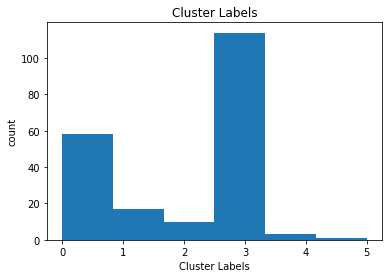

In [172]:
plt.pyplot.hist(london_merged["Cluster Labels"],bins=6)

# set x/y labels and plot title
plt.pyplot.xlabel("Cluster Labels")
plt.pyplot.ylabel("count")
plt.pyplot.title("Cluster Labels")

In [173]:
bins = np.linspace(min(london_merged["Cluster Labels"]), max(london_merged["Cluster Labels"]), 7)
bins

array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
       4.16666667, 5.        ])

In [197]:
group_names = ['Hotels and Social Venues','Stores','Pubs','Pubs and Cafes','Parks', 'Fish restaurants']

In [198]:
london_merged['Cluster-Category'] = pd.cut(london_merged['Cluster Labels'], bins, labels=group_names, include_lowest=True )
london_merged[['Cluster Labels','Cluster-Category']].head()

Cluster Labels          Cluster-Category
0               3            Pubs and Cafes
1               1                    Stores
2               5          Fish restaurants
3               0  Hotels and Social Venues
4               0  Hotels and Social Venues

# Final Data

In [200]:
london_merged.head()

Location London_borough Postcode_district  Avg_price   Latitude  \
0        Abbey Wood         Bexley               SE2     359190  51.492450   
1             Acton         Ealing                W3     553090  51.513240   
2         Addington        Croydon               CR0     345570  51.384755   
3       Albany Park         Bexley               DA5     472959  51.506420   
4  Aldborough Hatch      Redbridge               IG2     411242  51.506420   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0   0.121270               3           Supermarket                   Pub   
1  -0.267460               1                  Park           Gas Station   
2  -0.051499               5         Grocery Store           Zoo Exhibit   
3  -0.127210               0                 Hotel               Theater   
4  -0.127210               0                 Hotel               Theater   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop         Historic Site         Train Station   
1        Breakfast Spot     Indian Restaurant         Train Station   
2           Gaming Cafe     Fish & Chips Shop           Fish Market   
3                 Plaza   Monument / Landmark              Wine Bar   
4                 Plaza   Monument / Landmark              Wine Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Convenience Store              Platform           Zoo Exhibit   
1     Convenience Store         Grocery Store           Zoo Exhibit   
2           Flea Market           Flower Shop                  Food   
3     Outdoor Sculpture           Art Gallery                Garden   
4     Outdoor Sculpture           Art Gallery                Garden   

  9th Most Common Venue 10th Most Common Venue Price-Categories  \
0     Food & Drink Shop      Fish & Chips Shop      Low level 1   
1     Food & Drink Shop            Fish Market      Low level 1   
2     Food & Drink Shop             Food Court      Low level 1   
3                   Pub           Cocktail Bar      Low level 1   
4                   Pub           Cocktail Bar      Low level 1   

           Cluster-Category  
0            Pubs and Cafes  
1                    Stores  
2          Fish restaurants  
3  Hotels and Social Venues  
4  Hotels and Social Venues

# Creating Chloropleth map to visualize how London is divided in terms of Housing prices with cluster markers

In [276]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/ckaparakis/Coursera_Capstone/master/london_boroughs_proper.geojson") as url:
    lnd_geo = json.loads(url.read().decode())

In [277]:
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=london_merged,
    columns=['London_borough','Avg_price'],
    key_on='feature.properties.name',
    fill_color='RdPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average house Prices'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'],london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(lnd_map)
       
# display map
lnd_map

# Chloropleth map so to see how the London is clustered

In [278]:
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=london_merged,
    columns=['London_borough','Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='PuRd', 
    fill_opacity=0.7, 
    line_opacity=0.2
)

lnd_map



# Examining the Clusters

## Cluster 1

In [279]:
london_merged[london_merged['Cluster Labels']==0]

Location          London_borough Postcode_district  Avg_price  \
3         Albany Park                  Bexley               DA5     472959   
4    Aldborough Hatch               Redbridge               IG2     411242   
5             Aldgate                    City               EC3     896632   
6             Aldwych             Westminster               WC2    1786053   
7            Alperton                   Brent               HA0     445970   
10          Aperfield                 Bromley              TN16     453859   
18        Barkingside               Redbridge               IG6     477220   
25          Bayswater             Westminster                W2    1071238   
28          Becontree    Barking and Dagenham               RM9     312000   
29    Becontree Heath    Barking and Dagenham               RM8     316591   
32          Belgravia             Westminster               SW1    1528251   
34            Belmont                  Harrow               HA3     437803   
35            Belmont                  Sutton               SM2     364298   
38         Berrylands    Kingston upon Thames               KT5     477194   
61       Canning Town                  Newham               E16     478258   
62         Carshalton                  Sutton               SM5     417758   
63     Chadwell Heath               Redbridge               RM6     383261   
65        Chase Cross                Havering               RM5     375250   
66         Chelsfield                 Bromley               BR6     565987   
67        Chessington    Kingston upon Thames               KT9     421160   
68          Chinatown             Westminster                W1    2326750   
70          Chingford          Waltham Forest                E4     469228   
74        Cockfosters                  Barnet               EN4     791615   
79           Coulsdon                 Croydon               CR5     514922   
80             Cowley              Hillingdon               UB8     392659   
81           Cranford                Hounslow               TW5     487428   
88        Derry Downs                 Bromley               BR5     457777   
91        Earls Court  Kensington and Chelsea               SW5    1100901   
101          Elm Park                Havering              RM12     422464   
105     Finsbury Park                Haringey                N4     594471   
113         Goodmayes               Redbridge               IG3     498513   
116         Greenford                  Ealing               UB6     452413   
120          Hainault               Redbridge               IG7     578454   
121               Ham    Richmond upon Thames              TW10     755870   
123           Hampton    Richmond upon Thames              TW12     551851   
126         Harefield              Hillingdon               UB9     496058   
128     Harmondsworth              Hillingdon               UB7     385391   
129       Harold Hill                Havering               RM3     353337   
131             Hayes                 Bromley               BR2     470380   
136      Holland Park  Kensington and Chelsea                W8    1861385   
139          Ickenham              Hillingdon              UB10     536498   
142            Kenley                 Croydon               CR8     440184   
144        Kensington  Kensington and Chelsea               SW7    1957272   
145               Kew    Richmond upon Thames               TW9     730973   
147           Lampton                Hounslow               TW4     357450   
162          Northolt                  Ealing               UB5     335101   
163         Northwood              Hillingdon               HA6     574430   
164     Norwood Green                  Ealing               UB2     393520   
168        Old Malden    Kingston upon Thames               KT4     531493   
178           Ruislip              Hillingdon               HA4     501721   
180       Sanderstead              

## Cluster 2

In [281]:
london_merged[london_merged['Cluster Labels']==1]

Location        London_borough Postcode_district  Avg_price  \
1             Acton                Ealing                W3     553090   
8           Anerley               Bromley              SE20     359134   
14      Arnos Grove               Enfield               N11     490953   
17          Barking  Barking and Dagenham              IG11     283965   
33       Bellingham              Lewisham               SE6     372810   
40         Blackfen                Bexley              DA15     462706   
49       Brent Park                 Brent              NW10     514854   
69        Chinbrook              Lewisham              SE12     437186   
97     East Wickham                Bexley              DA16     396951   
103    Enfield Town               Enfield               EN1     435619   
107     Forest Gate                Newham                E7     446607   
124    Hampton Wick  Richmond upon Thames               KT1     512896   
140          Ilford             Redbridge               IG1     395298   
172       Plumstead             Greenwich              SE18     414199   
179      Rush Green  Barking and Dagenham               RM7     365020   
191      Thamesmead                Bexley              SE28     277857   
192  Thornton Heath               Croydon               CR7     356521   

      Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
1    51.513240  -0.267460               1                  Park   
8    51.410090  -0.056830               1           Supermarket   
14   51.616310  -0.138390               1         Grocery Store   
17   51.533120   0.084077               1         Grocery Store   
33   51.437220  -0.018680               1           Pizza Place   
40   51.452281   0.099797               1         Grocery Store   
49   51.539160  -0.251230               1         Grocery Store   
69   51.447590   0.013500               1    Italian Restaurant   
97   51.459075   0.099121               1     Indian Restaurant   
103  51.641312  -0.074635               1                 Hotel   
107  51.546680   0.025580               1         Grocery Store   
124  51.351429  -0.249881               1         Grocery Store   
140  51.551160   0.078960               1         Grocery Store   
172  51.482070   0.071430               1              Bus Stop   
179  51.574088   0.167940               1             Racetrack   
191  51.505270   0.120130               1           Sports Club   
192  51.396315  -0.106608               1              Bus Stop   

      2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
1               Gas Station        Breakfast Spot           Indian Restaurant   
8             Grocery Store     Convenience Store        Fast Food Restaurant   
14                 Bus Stop     Convenience Store                    Beer Bar   
17                      Spa           Supermarket                       Plaza   
33   Furniture / Home Store        Discount Store               Train Station   
40                 Bus Stop             Gastropub           Convenience Store   
49           Clothing Store        Sandwich Place                        Café   
69        Fish & Chips Shop                   Pub               Train Station   
97            Grocery Store           Pizza Place  Construction & Landscaping   
103             Coffee Shop         Train Station               Grocery Store   
107                     Pub  Fast Food Restaurant                    Bus Stop   
124       Convenience Store    Italian Restaurant                 Beer Garden   
140     Fried Chicken Joint        Ice Cream Shop            Asian Restaurant   
172       Indian Restaurant    Chinese Restaurant   Middle Eastern Restaurant   
179           Grocery Store           Zoo Exhibit                  Food Court   
191                Bus Stop     Convenience Store                Food Service   
192                     Pub     Martial Arts Dojo           Indian Restaurant   

          5t

## Cluster 3

In [282]:
london_merged[london_merged['Cluster Labels']==2]

Location        London_borough Postcode_district  Avg_price  \
19      Barnehurst                Bexley               DA7     432727   
20          Barnes  Richmond upon Thames              SW13     997701   
21     Barnes Cray                Bexley               DA1     297837   
75       Colindale                Barnet               NW9     446260   
76   Colliers Wood                Merton              SW19     575488   
77         Colyers                Bexley               DA8     311737   
78          Coombe  Kingston upon Thames               KT2     635491   
115    Grange Park               Enfield               N21     567812   
133       Highbury             Islington                N5     659974   
134       Highgate                Camden                N6     857829   

      Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
19   51.470520   0.146706               2                   Pub   
20   51.474570  -0.242120               2                   Pub   
21   51.452068   0.172230               2    Italian Restaurant   
75   51.584860  -0.248810               2              Bus Stop   
76   51.421700  -0.207960               2                   Pub   
77   51.506420  -0.127210               2                 Hotel   
78   51.410874  -0.291946               2     Indian Restaurant   
115  51.635190  -0.093030               2    Italian Restaurant   
133  51.553180  -0.098390               2                  Café   
134  51.571450  -0.149830               2                   Pub   

    2nd Most Common Venue     3rd Most Common Venue 4th Most Common Venue  \
19      Indian Restaurant                    Forest     Convenience Store   
20                   Park               Pizza Place        Farmers Market   
21                    Pub  Mediterranean Restaurant         Track Stadium   
75       Asian Restaurant                       Pub                 Hotel   
76            Coffee Shop            Clothing Store                   Bar   
77                Theater                     Plaza   Monument / Landmark   
78     Italian Restaurant                      Café                   Pub   
115           Supermarket                  Bus Stop                  Café   
133         Deli / Bodega                Restaurant             Bookstore   
134                Bakery               Coffee Shop           Pizza Place   

         5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
19                 Zoo Exhibit            Food Court     Fish & Chips Shop   
20                 Coffee Shop                Bakery         Movie Theater   
21                 Supermarket  Medical Supply Store                  Food   
75                        Café     Mobile Phone Shop           Supermarket   
76            Sushi Restaurant          Burger Joint         Grocery Store   
77                    Wine Bar     Outdoor Sculpture           Art Gallery   
78                        Food             Gastropub    Seafood Restaurant   
115              Grocery Store            Food Stand           Flea Market   
133  Middle Eastern Restaurant           Cheese Shop     Fish & Chips Shop   
134                       Café             Gastropub              Tea Room   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
19            Fish Market           Flea Market            Flower Shop   
20         Breakfast Spot             Gastropub      Food & Drink Shop   
21     Frozen Yogurt Shop   Fried Chicken Joint      Fish & Chips Shop   
75       Sushi Restaurant         Auto Workshop             Hookah Bar   
76            Supermarket              Creperie         Sandwich Place   
77                 Garden                   Pub           Cocktail Bar   
78        Thai Restaurant           Supermarket                    Bar   
115           Flower Shop                  Food      Food & Drink Shop   
133      Tapas Restaurant          Tennis Court        Thai Restaurant   
134                  

## Cluster 4

In [283]:
london_merged[london_merged['Cluster Labels']==3]

Location  \
0                                        Abbey Wood   
9                                             Angel   
11                                          Archway   
12                                   Ardleigh Green   
13                                           Arkley   
15                                           Balham   
16                                         Bankside   
22                                      Barnet Gate   
23                                        Barnsbury   
24                                        Battersea   
26                                        Beckenham   
27                                          Beckton   
30                                       Beddington   
31                                     Bedford Park   
36                                     Belsize Park   
37                                        Belvedere   
39                                    Bethnal Green   
42                                        Blackwall   
43                                       Bloomsbury   
45                                              Bow   
46                                       Bowes Park   
47                                        Brentford   
48                                      Brent Cross   
50                                        Brimsdown   
51                                          Brixton   
52                                         Brockley   
53                                         Plaistow   
54                                         Brompton   
55                                      Brondesbury   
56                                        Burnt Oak   
57                                   Burroughs, The   
58                                       Camberwell   
59                                      Camden Town   
60                                        Cann Hall   
64                                         Charlton   
71                                      Chislehurst   
72                                       Church End   
73                                          Clapham   
83                                       Crouch End   
84                                   Crystal Palace   
85                                           Cudham   
86                                          Dalston   
87                                         Deptford   
89                                          Dulwich   
90                                           Ealing   
92                                       Earlsfield   
93                                     East Bedfont   
94                                     East Dulwich   
95                                    East Finchley   
96                                       East Sheen   
98                                         Eastcote   
99                                         Edmonton   
100                                  Eel Pie Island   
102                                          Eltham   
104                                         Feltham   
106                                      Foots Cray   
108                                     Forest Hill   
109                                    Fortis Green   
110                                          Fulham   
111                                         Fulwell   
112                                   Golders Green   
114                                      Gospel Oak   
117                                       Greenwich   
118                                         Hackney   
119                                 Hackney Marshes   
122                                     Hammersmith   
125                                         Hanwell   
127                                      Harlington   
130                                          Harrow   
132                                      Herne Hill   
135                                    Hither Green   
137                                        Holloway   
138                         

## Cluster 5

In [284]:
london_merged[london_merged['Cluster Labels']==4]

Location London_borough Postcode_district  Avg_price   Latitude  \
41  Blackheath       Lewisham               SE3     507800  51.471380   
44  Botany Bay        Enfield               EN2     559788  51.653660   
82     Cranham       Havering              RM14     542083  51.543074   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
41   0.023380               4                   Pub           Zoo Exhibit   
44  -0.110614               4                   Pub                  Lake   
82   0.250114               4                  Park                   Pub   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
41          Food Service     Fish & Chips Shop           Fish Market   
44           Zoo Exhibit          Food Service     Fish & Chips Shop   
82           Zoo Exhibit          Food Service           Fish Market   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
41           Flea Market           Flower Shop                  Food   
44           Fish Market           Flea Market           Flower Shop   
82           Flea Market           Flower Shop                  Food   

   9th Most Common Venue 10th Most Common Venue Price-Categories  \
41     Food & Drink Shop             Food Court      Low level 1   
44                  Food      Food & Drink Shop      Low level 1   
82     Food & Drink Shop             Food Court      Low level 1   

   Cluster-Category  
41            Parks  
44            Parks  
82            Parks

## Cluster 6

In [285]:
london_merged[london_merged['Cluster Labels']==5]

Location London_borough Postcode_district  Avg_price   Latitude  \
2  Addington        Croydon               CR0     345570  51.384755   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
2  -0.051499               5         Grocery Store           Zoo Exhibit   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2           Gaming Cafe     Fish & Chips Shop           Fish Market   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2           Flea Market           Flower Shop                  Food   

  9th Most Common Venue 10th Most Common Venue Price-Categories  \
2     Food & Drink Shop             Food Court      Low level 1   

   Cluster-Category  
2  Fish restaurants

# Examining Property prices

In [287]:
london_merged[london_merged['Price-Categories']=='High level 2']

Location London_borough Postcode_district  Avg_price  Latitude  \
68  Chinatown    Westminster                W1    2326750  51.51656   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
68    -0.1477               0     French Restaurant           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
68             Juice Bar          Burger Joint    Italian Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
68        Clothing Store                  Café                 Hotel   

   9th Most Common Venue 10th Most Common Venue Price-Categories  \
68                Bakery            Art Gallery     High level 2   

            Cluster-Category  
68  Hotels and Social Venues

In [288]:
london_merged[london_merged['Price-Categories']=='High level 1']

Location                                London_borough  \
6         Aldwych                                   Westminster   
54       Brompton  Kensington and ChelseaHammersmith and Fulham   
136  Holland Park                        Kensington and Chelsea   
144    Kensington                        Kensington and Chelsea   

    Postcode_district  Avg_price  Latitude  Longitude  Cluster Labels  \
6                 WC2    1786053  51.51651   -0.11968               0   
54                SW3    1759506  51.49014   -0.16248               3   
136                W8    1861385  51.50162   -0.19173               0   
144               SW7    1957272  51.49807   -0.17404               0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
6                 Theater           Coffee Shop     Korean Restaurant   
54                    Pub   Japanese Restaurant                  Café   
136                 Hotel                  Café                   Pub   
144                  Café               Exhibit                 Hotel   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
6              Restaurant                 Hotel                   Pub   
54         Clothing Store    Italian Restaurant    English Restaurant   
136            Restaurant        Clothing Store             Juice Bar   
144        Science Museum    Italian Restaurant                Garden   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
6     Japanese Restaurant        Clothing Store                Bakery   
54   Gym / Fitness Center                 Hotel           Coffee Shop   
136                Bakery    Italian Restaurant         Grocery Store   
144                   Bar                Bakery             Gift Shop   

    10th Most Common Venue Price-Categories          Cluster-Category  
6             Burger Joint     High level 1  Hotels and Social Venues  
54          Ice Cream Shop     High level 1            Pubs and Cafes  
136      French Restaurant     High level 1  Hotels and Social Venues  
144         Sandwich Place     High level 1  Hotels and Social Venues

In [289]:
london_merged[london_merged['Price-Categories']=='Low level 2']

Location          London_borough Postcode_district  Avg_price  \
11            Archway               Islington               N19     588191   
13             Arkley                  Barnet               EN5     616027   
15             Balham              Wandsworth              SW12     641958   
22        Barnet Gate                  Barnet               NW7     692953   
23          Barnsbury               Islington                N1     765749   
24          Battersea              Wandsworth              SW11     823697   
31       Bedford Park                  Ealing                W4     676221   
39      Bethnal Green           Tower Hamlets                E2     661547   
42          Blackwall           Tower Hamlets               E14     585067   
48        Brent Cross                  Barnet               NW2     579826   
55        Brondesbury                   Brent               NW6     709849   
72         Church End                  Barnet                N3     693494   
73            Clapham                 Lambeth               SW4     681547   
74        Cockfosters                  Barnet               EN4     791615   
76      Colliers Wood                  Merton              SW19     575488   
78             Coombe    Kingston upon Thames               KT2     635491   
85             Cudham                 Bromley              TN14     589032   
86            Dalston                 Hackney                E8     672353   
90             Ealing                  Ealing                W5     679911   
92         Earlsfield              Wandsworth              SW18     598102   
95      East Finchley                  Barnet                N2     717566   
98           Eastcote              Hillingdon               HA5     634605   
100    Eel Pie Island    Richmond upon Thames               TW1     627595   
105     Finsbury Park                Haringey                N4     594471   
109      Fortis Green                Haringey               N10     605188   
111           Fulwell    Richmond upon Thames              TW11     631666   
112     Golders Green                  Barnet              NW11     817621   
114        Gospel Oak                  Camden               NW5     724220   
117         Greenwich               Greenwich              SE10     571519   
120          Hainault               Redbridge               IG7     578454   
121               Ham    Richmond upon Thames              TW10     755870   
122       Hammersmith  Hammersmith and Fulham                W6     822672   
132        Herne Hill                 Lambeth              SE24     598329   
133          Highbury               Islington                N5     659974   
134          Highgate                  Camden                N6     857829   
143        Kennington                 Lambeth              SE11     626740   
145               Kew    Richmond upon Thames               TW9     730973   
146     Kingston Vale    Kingston upon Thames              SW15     630670   
151     Little Venice             Westminster                W9     818526   
154          Mile End           Tower Hamlets                E1     629076   
156      Motspur Park    Kingston upon Thames               KT3     610836   
161  North Kensington  Kensington and Chelsea               W10     775419   
163         Northwood              Hillingdon               HA6     574430   
167     Oakleigh Park                  Barnet               N20     744090   
169            Osidge                  Barnet               N14     667442   
175       Raynes Park                  Merton              SW20     675154   
183   Shepherd's Bush  Hammersmith and Fulham               W12     786508   
187          Stanmore                  Harrow               HA7     608786   
188   Stoke Newington                 Hackney               N16     573516   
195          Walworth               Southwark              SE17     575525   
197       West Ealing              

In [290]:
london_merged[london_merged['Price-Categories']=='Low level 1']

Location        London_borough  \
0                                        Abbey Wood                Bexley   
1                                             Acton                Ealing   
2                                         Addington               Croydon   
3                                       Albany Park                Bexley   
4                                  Aldborough Hatch             Redbridge   
7                                          Alperton                 Brent   
8                                           Anerley               Bromley   
10                                        Aperfield               Bromley   
12                                   Ardleigh Green              Havering   
14                                      Arnos Grove               Enfield   
17                                          Barking  Barking and Dagenham   
18                                      Barkingside             Redbridge   
19                                       Barnehurst                Bexley   
21                                      Barnes Cray                Bexley   
26                                        Beckenham               Bromley   
27                                          Beckton                Newham   
28                                        Becontree  Barking and Dagenham   
29                                  Becontree Heath  Barking and Dagenham   
30                                       Beddington                Sutton   
33                                       Bellingham              Lewisham   
34                                          Belmont                Harrow   
35                                          Belmont                Sutton   
37                                        Belvedere                Bexley   
38                                       Berrylands  Kingston upon Thames   
40                                         Blackfen                Bexley   
41                                       Blackheath              Lewisham   
44                                       Botany Bay               Enfield   
45                                              Bow         Tower Hamlets   
46                                       Bowes Park              Haringey   
47                                        Brentford              Hounslow   
49                                       Brent Park                 Brent   
50                                        Brimsdown               Enfield   
51                                          Brixton               Lambeth   
52                                         Brockley              Lewisham   
53                                         Plaistow               Bromley   
56                                        Burnt Oak                Barnet   
57                                   Burroughs, The                Barnet   
58                                       Camberwell             Southwark   
60                                        Cann Hall        Waltham Forest   
61                                     Canning Town                Newham   
62                                       Carshalton                Sutton   
63                                   Chadwell Heath             Redbridge   
64                                         Charlton             Greenwich   
65                                      Chase Cross              Havering   
66                                       Chelsfield               Bromley   
67                                      Chessington  Kingston upon Thames   
69                                        Chinbrook              Lewisham   
70                                        Chingford        Waltham Forest   
71                                      Chislehurst               Bromley   
75                                        Colindale                Barnet   
77                                          Colyers                Bexley   
79                                     